In [833]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.model_selection
import itertools
import statsmodels.api as sm
import warnings
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from pypfopt.efficient_frontier import EfficientFrontier

In [834]:
# de-annualize yearly interest rates
def deannualize(annual_rate, periods=365):
    return (1 + annual_rate) ** (1/periods) - 1

def get_risk_free_rate():
    # download 3-month us treasury bills rates
    annualized = yf.download("^IRX", start="2010-01-01", end="2019-12-31")["Adj Close"]
    
    # de-annualiz
    daily = annualized.apply(deannualize)

    # create dataframe
    return pd.DataFrame({"annualized": annualized, "daily": daily}) 

rates = get_risk_free_rate()/100
rates

[*********************100%***********************]  1 of 1 completed


,annualized,daily
Date,,
2010-01-04,0.00055,0.000001
2010-01-05,0.00060,0.000002
2010-01-06,0.00045,0.000001
2010-01-07,0.00045,0.000001
2010-01-08,0.00040,0.000001
...,...,...
2019-12-23,0.01520,0.000025
2019-12-24,0.01538,0.000026
2019-12-26,0.01535,0.000026


In [835]:
table=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
df = table[0]
df = df[df["Date added"] <= "2010"]
df2 = df.groupby('GICS Sector', as_index=False).nth([0,1,2,3,4])

In [836]:
l = list(df2['Symbol'])
l.remove("BF.B")
data = yf.download(l, start="2011-01-01", end="2019-12-31", interval="1d")
data = data['Adj Close']
data = data.pct_change()
data = data.dropna()
data
None

[*********************100%***********************]  54 of 54 completed


In [837]:
data_df = data.copy()
data_df
None

In [838]:
'''
data_tr = data[data.index < "2014-05-07"]
data_dv = data[(data.index >= "2014-05-07")&(data.index < "2015-08-31")]
data_tst = data[data.index >= "2015-08-31"]
'''
data_tr = data[data.index < "2015"]
data_dv = data[(data.index >= "2015")&(data.index < "2016")]
data_tst = data[data.index >= "2016"]


In [840]:
X_tr = np.log(1+np.array(data_tr).transpose()).astype("float32")
X_tst = np.log(1+np.array(data_tst).transpose()).astype("float32")
X_dv = np.log(1+np.array(data_dv).transpose()).astype("float32")


In [841]:
X_input_tr = X_tr[:,:,None]
X_input_tst = X_tst[:,:,None]
X_input_dv = X_dv[:,:,None]

In [842]:
train_loader = torch.utils.data.DataLoader(X_input_tr, batch_size=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(X_input_tst, batch_size = X_tst.shape[0],shuffle=True)
dev_loader = torch.utils.data.DataLoader(X_input_dv, batch_size = X_tst.shape[0],shuffle=True)

In [843]:
data_inf = data[data.index < "2016"]
X_inf = np.log(1+np.array(data_inf).transpose()).astype("float32")
X_input_inf = X_inf[:,:,None]
inf_loader = torch.utils.data.DataLoader(X_input_inf, batch_size = X_input_inf.shape[0],shuffle=True)
inf_batch = next(inf_loader.__iter__())
inf_batch.shape
inf1 = inf_loader

In [844]:
data_inf = data[data.index >= "2015"]
X_inf = np.log(1+np.array(data_inf).transpose()).astype("float32")
X_input_inf = X_inf[:,:,None]
inf_loader = torch.utils.data.DataLoader(X_input_inf, batch_size = X_input_inf.shape[0],shuffle=True)
inf_batch = next(inf_loader.__iter__())
inf_batch.shape
inf2 = inf_loader

In [845]:
example_batch = next(inf_loader.__iter__())
#example_batch
#example_batch = next(test_loader.__iter__())
#example_batch.shape

In [864]:
class pred_lstm(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_size = 1
        self.hidden_units = 5
        
        self.num_layers = 4
        
        self.lstm = nn.LSTM(
            input_size = self.input_size, 
            hidden_size = self.hidden_units, 
            num_layers = self.num_layers, 
            bidirectional = False,
            batch_first=True)        
        '''
        self.lstm = nn.RNN(
            input_size=self.input_size, # because x is in R^1
            hidden_size=self.hidden_units, # we'll try a 10-dimensional hidden state
            nonlinearity="relu", # use ReLU for the activation to the hidden state
            batch_first=True, # tell RNN our data X has the observation as its first dimension, not its second
        )
        '''
        
        # Now convert the 10-dimensional hidden state to a 1-dimensional output
        self.linear = nn.Linear(in_features = self.hidden_units , 
                                out_features = 1)
    def forward(self, x):
        # notice that the layer returns a tuple -- it also provides the final hidden states.
        # We don't need those here, and this interferes with using nn.Sequential(), because
        # the linear layer does not expect a tuple as input.
        lstm_out, hidden_states = self.lstm(x) 
        return self.linear(lstm_out)

In [865]:
def train(network, optimizer, train_loader, test_loader, n_epochs=3, log_interval=50, verbose=False):
    """Train a network with a particular optimizer.
    
    network: a `nn.Module` object representing the neural network to train
    optimizer: a PyTorch optimizer, such as SGD
    train_loader: a `DataLoader` object containing the training data, potentially in batches
    test_loader: the same, but for the testing data
    n_epochs: number of epochs of training to run
    log_interval: after how many batches should record our progress?
    verbose: print the progress after each log_interval steps?
    
    Returns a tuple (train_losses, counter, test_losses). train_losses is a list of 
    losses after every log_interval training steps; train_counter is a list giving the number
    of training observations seen by the training process by each of those steps; test_losses
    gives the test-set loss before each epoch and after the final epoch; test_counter gives
    the number of training observations seen at each epoch.
    """
    
    # Store the losses we observe during training
    train_losses = []
    test_losses = []
    train_counter = []
    test_counter = []
    
    samples_seen = 0 # number of observations used in training
    
    for epoch in range(n_epochs):
        #print("new_epoch")
        # test at the beginning of each epoch
        test_loss = test(network, test_loader)
        test_losses.append(test_loss)
        test_counter.append(samples_seen)
        
        network.train() # put the network in training mode

        for batch_idx, data in enumerate(train_loader):
            # Reset all gradients
            optimizer.zero_grad()
    
            # data is now a (N, L, 1) matrix. Let's get the network's predictions using L-1 of the samples
            predictions = network(data[:, :-1, :])
    
            # Get the MAE loss on predicting the next observation
            loss = F.mse_loss(predictions, data[:, 1:, :])
    
            # Calculate the gradients with backpropagation
            loss.backward()
    
            # Perform one gradient descent step
            optimizer.step()

            # Count how much data we've seen
            samples_seen += len(data)
            
            # Every log_interval steps, print out the progress
            if batch_idx % log_interval == 0:
                if verbose:
                    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        epoch + 1, batch_idx * len(data), len(train_loader.dataset),
                        100.0 * batch_idx / len(train_loader), loss.item()))
                
                train_losses.append(loss.item())
                train_counter.append(samples_seen)
                

    # test after the final epoch
    test_loss = test(network, test_loader)
    test_losses.append(test_loss)
    test_counter.append(samples_seen)

    return train_losses, train_counter, test_losses, test_counter

In [866]:
def test(network, loader):
    """Test a network model on the test data.
    
    network: a `nn.Module` object representing the neural network to test
    loader: a `DataLoader` object containing the testing data, potentially in batches
    
    Returns the average loss on the test data.
    """
    
    # Put the network in evaluation mode
    network.eval()
    
    test_loss = 0
    
    # don't track gradients during this calculation
    with torch.no_grad():
        for data in loader:
            output = network(data[:, :-1, :])
            
            # calculate the absolute loss on this batch
            test_loss += F.mse_loss(output, data[:, 1:, :], reduction='sum').item()

    # get the overall loss across all batches
    test_loss /= len(loader.dataset)
    
    return test_loss

In [867]:
def test_pred(network,loader):
    network.eval()
    output_arr = []
    # don't track gradients during this calculation
    with torch.no_grad():
        for data in loader:
            output = network(data)
            output_arr.append(output)
    if len(output_arr) == 1:
        return output_arr[0]
    else:
        return output_arr

In [868]:
lstm_network = pred_lstm()
optimizer = optim.RMSprop(lstm_network.parameters())

In [869]:
%%time
train_losses, train_counter, test_losses, test_counter = train(
    lstm_network, optimizer, train_loader, dev_loader, n_epochs=2, log_interval = 50, verbose=True) #50 later

Train Epoch: 1 [0/54 (0%)]	Loss: 0.105977
Train Epoch: 1 [50/54 (93%)]	Loss: 0.000207
Train Epoch: 2 [0/54 (0%)]	Loss: 0.000250
Train Epoch: 2 [50/54 (93%)]	Loss: 0.000817
CPU times: total: 5min 23s
Wall time: 3min 11s


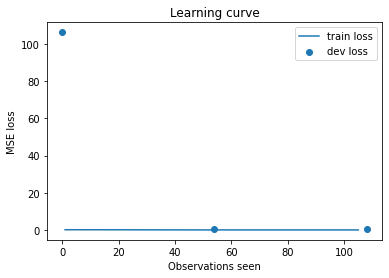

In [871]:
plt.plot(train_counter, train_losses,label = "train loss")
plt.scatter(test_counter, test_losses,label = "dev loss")
plt.legend()
plt.xlabel("Observations seen")
plt.ylabel("MSE loss")
plt.title("Learning curve");

In [872]:
def returns(actual_returns, weights):
    return np.dot(actual_returns.T, weights)

def portfolio_optimize(predicted_returns, variances, risk_free):
    ef = EfficientFrontier(predicted_returns, variances, weight_bounds = (0,1))
    weights = ef.max_sharpe(risk_free_rate = risk_free)  
    
    tangencyweights = []
    for i in weights.values():
        tangencyweights.append(float(i))
    
    tangencyweights = np.array(tangencyweights)
    return tangencyweights

def wrapper(input_features, predicted_returns, actual_returns, risk_free):
    variances = np.cov(input_features)
    weights = portfolio_optimize(predicted_returns, variances, risk_free)  
    return returns(actual_returns, weights)


In [873]:
cur_batch.shape

torch.Size([54, 1257, 1])

In [874]:
#extrinsic performance for dev set
cur_loader = inf2
cur_batch = next(cur_loader.__iter__())
cur_data = X_tst
preds = test_pred(lstm_network,cur_loader)
preds_req = preds[:,-1*(cur_data.shape[1]):,0]
#convert to exp to get back to normal numbers
pred_returns = np.exp(preds_req.detach().numpy())-1
act_returns = np.exp(cur_batch[:,-1*(cur_data.shape[1]):,0].detach().numpy())-1

In [875]:
results = []
for i in range(cur_data.shape[1]):  
    if i < 61:
        continue
    input_features = cur_data[:,i-60:i]
    predicted_returns = pred_returns[:,i-1].reshape(cur_data.shape[0],1)
    actual_returns = act_returns[:,i].reshape(cur_data.shape[0],1)
    try:
        date = data_tst.iloc[i-1].name
        rf_rate = rates['daily'][date]
    except:
        rf_rate = rates['daily'][data_tst.iloc[i-2].name]
    try:
        results.append(wrapper(input_features, predicted_returns, actual_returns, rf_rate))
    except:
        results.append(wrapper(cur_data[:,i-61:i-1], pred_returns[:,i-2].reshape(cur_data.shape[0],1), actual_returns, rf_rate))            
    
rst = [l[0] for l in results]
cumulative_returns = np.cumprod(np.array(rst) + 1)

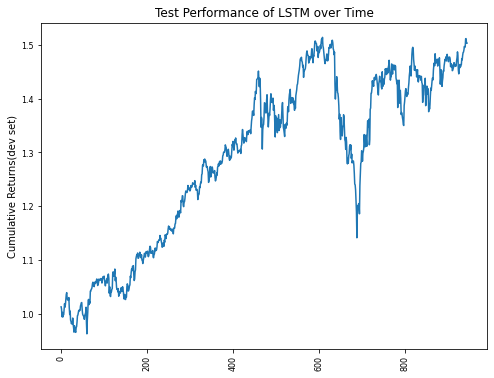

In [876]:
fig = plt.figure(figsize=(8,6))
#plt.plot(dates[-1092:], svr_cumulative_returns)
plt.plot(range(len(cumulative_returns)), cumulative_returns)
#plt.xlabel('Time')
plt.xticks(rotation = 'vertical', fontsize=8)
plt.ylabel('Cumulative Returns(test set)')
plt.yticks(fontsize=8)
plt.title('Test Performance of RNN over Time')
plt.show()

In [877]:

final = preds.detach().numpy()
final = final[:,-1093:-1,:]

In [878]:
blah = pd.DataFrame({"lstm" : final.reshape(-1)})
blah.to_csv("RNN.csv")


In [879]:
blah.shape

(58968, 1)

In [861]:
#extrinsic performance for dev set
cur_loader = inf1
cur_batch = next(cur_loader.__iter__())
cur_data = X_dv
preds = test_pred(lstm_network,cur_loader)
preds_req = preds[:,-1*(cur_data.shape[1]):,0]
#convert to exp to get back to normal numbers
pred_returns = np.exp(preds_req.detach().numpy())-1
act_returns = np.exp(cur_batch[:,-1*(cur_data.shape[1]):,0].detach().numpy())-1

In [862]:
results = []
for i in range(cur_data.shape[1]):  
    if i < 61:
        continue
    input_features = cur_data[:,i-60:i]
    predicted_returns = pred_returns[:,i-1].reshape(cur_data.shape[0],1)
    actual_returns = act_returns[:,i].reshape(cur_data.shape[0],1)
    try:
        date = data_tst.iloc[i-1].name
        rf_rate = rates['daily'][date]
    except:
        rf_rate = rates['daily'][data_dv.iloc[i-2].name]
    try:
        results.append(wrapper(input_features, predicted_returns, actual_returns, rf_rate))
    except:
        results.append(wrapper(cur_data[:,i-61:i-1], pred_returns[:,i-2].reshape(cur_data.shape[0],1), actual_returns, rf_rate))            
    
rst = [l[0] for l in results]
cumulative_returns = np.cumprod(np.array(rst) + 1)

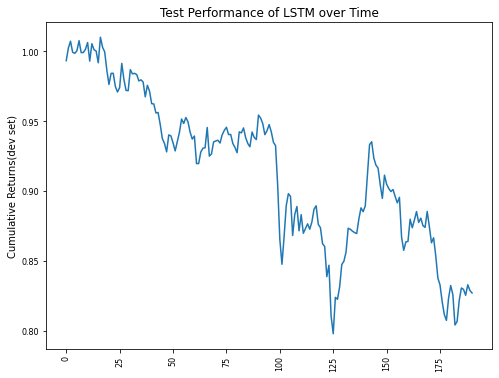

In [863]:
fig = plt.figure(figsize=(8,6))
#plt.plot(dates[-1092:], svr_cumulative_returns)
plt.plot(range(len(cumulative_returns)), cumulative_returns)
#plt.xlabel('Time')
plt.xticks(rotation = 'vertical', fontsize=8)
plt.ylabel('Cumulative Returns(dev set)')
plt.yticks(fontsize=8)
plt.title('Test Performance of RNN over Time')
plt.show()